# Stockes Flow

In [1]:
#importing libraries
import numpy
import numba
from numba import jit
from matplotlib import pyplot
%matplotlib inline

#defining grid
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

#initial guess
p = numpy.zeros((ny,nx))
w = numpy.ones((ny,nx))

#dérivative of p along the top border
u=1.

l1_target = 1e-6

In [2]:
@jit
def L1norm(new, old):
    '''Calculate l1 norm between new and old
    
    Parameters:
    ----------
    new : Array of floats
        
    old : Array of floats
    
    Returns:
    -------
    norm : double
            value of the l1 Norm
    '''
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [3]:
@jit
def poisson_2d_1step(p, b, dx, dy):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    pd = p.copy()
   
    p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 + (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2 - b[1:-1,1:-1]*dx**2*dy**2)
    
    #enforcing BC elsewhere
    return p 

def laplace_2d_1step(p, dx, dy):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    dx: float
         spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    pd = p.copy()
    
    p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 + (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2)
    
    #enforcing BC elsewhere   
    return p


In [4]:
@jit
def enforceBCphi(p):
    '''Enforce the boundary conditions for phi
    
    Parameters:
    ----------
    p : 2D array of floats
        solution before applying BC
    
    Returns:
    -------
    p_out : 2D array of floats
        solution after applying BC
    '''
#dirichlet condition
    p_out=p.copy()
    #top
    p_out[:,-1]=0.
    #bottom
    p_out[:,0]=0.
    #left
    p_out[0,:]=0.
    #right
    p_out[-1,:]=0.
    
    return p

def enforceBCw(w,p,dx,dy,u):
    '''Enforce boundary conditions for w
    
    Parameters:
    ----------
    w : solution before applying BC
    p : source term for bc
    dx : 
    
    
    Returns:
    -------
    w_out : solution after applying BC 
    '''
    
    #neumann + laplace
    w_out=w.copy()
    #bottom
    w_out[0,:]=-(8*p[1,:]-p[2,:])/2/dy/dy
    #left
    w_out[1:-1,0]=-(8*p[1:-1,1]-p[1:-1,2])/2/dx/dx
    #right
    w_out[1:-1,-1]=-(8*p[1:-1,-2]-p[1:-1,-3])/2/dx/dx
    #top
    w_out[-1,:]=-(8*p[-2,:]-p[-3, :])/2/dy/dy - 3*u/dy
    return w_out


In [5]:
#solve the biharmonic équation as a laplace and a poisson coupled equation
@jit
def biHarmonicSolver(p, w, dx, dy, l1Target, u):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array
        initial guess for p
    w : 2D array
        initial quess for w
    dx : float
        grid width in x
    dy : float
        grid width in y
    l1Target : float
        Target for the l1 norm between two iteration
    u : float
        parameter for bc
    
    Returns:
    -------
    p: 2D array
        solution for p
    w: 2D array
        solution for w
    l1phi : float
        l1 norm between two last iteration for p
    l1w : float
        l1 norm between two last iteration for w
    '''
    l1phi=l1Target+1
    l1w=l1Target+1
    nbStep=0
    #we have to force a few loop for the problem to start converging fast enough for l1-norm > target l1-norm
    while l1phi>l1Target or l1w>l1Target or nbStep<=2:
        pd=p.copy()
        wd=w.copy()
        p= poisson_2d_1step(pd, -wd, dx, dy)
        p = enforceBCphi(pd)
        l1phi= L1norm(p, pd)
        w = laplace_2d_1step(wd, dx, dy)
        w = enforceBCw(wd, pd, dx, dy, u)
        l1w=L1norm(w, wd)
        nbStep=nbStep+1
    #print("number of steps: ")
    #print(nbStep)
    return p, w, l1phi, l1w

In [6]:
#we solve équation and check the résult
p, w, l1phi, l1w = biHarmonicSolver(p, w, dx, dy, l1_target, u)
#we check that l1-norm is < target
print(l1phi, l1w)

3468
0.0 9.94664896860481e-07


<function matplotlib.pyplot.colorbar>

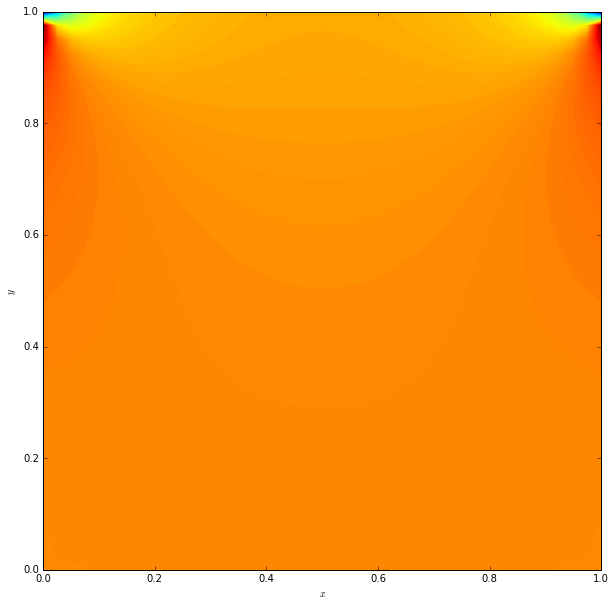

In [7]:
#print w
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(10,10))
pyplot.contourf(x,y,w,200)
#pyplot.contourf(x, y, p, 20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar

<function matplotlib.pyplot.colorbar>

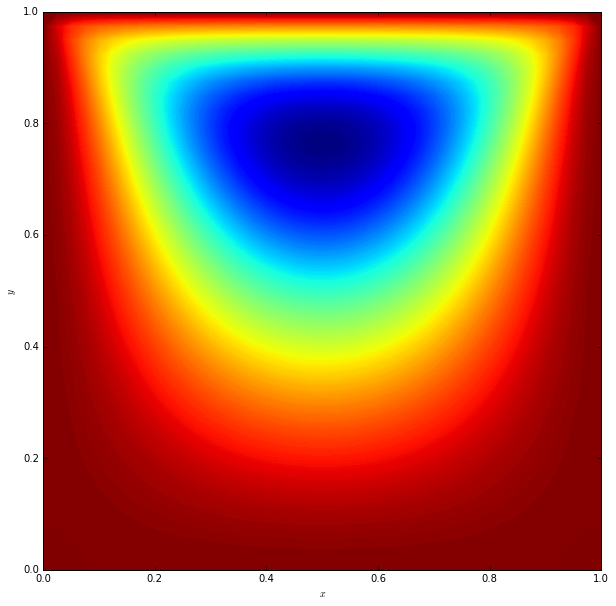

In [8]:
#print phi
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(10,10))
#pyplot.contourf(x,y,w,20)
pyplot.contourf(x, y, p, 200)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
